In [53]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('png')
plt.rcParams['figure.dpi'] = 300 
plt.rcParams['savefig.dpi'] = 300
import datetime
from sklearn import preprocessing

In [54]:
import requests
from pathlib import Path
from tqdm import tqdm, trange
import pickle
import gzip
import torch.nn.functional as F
import torch.nn as nn
import graphviz

In [55]:
with gzip.open('./mnist/mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_test, y_test), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

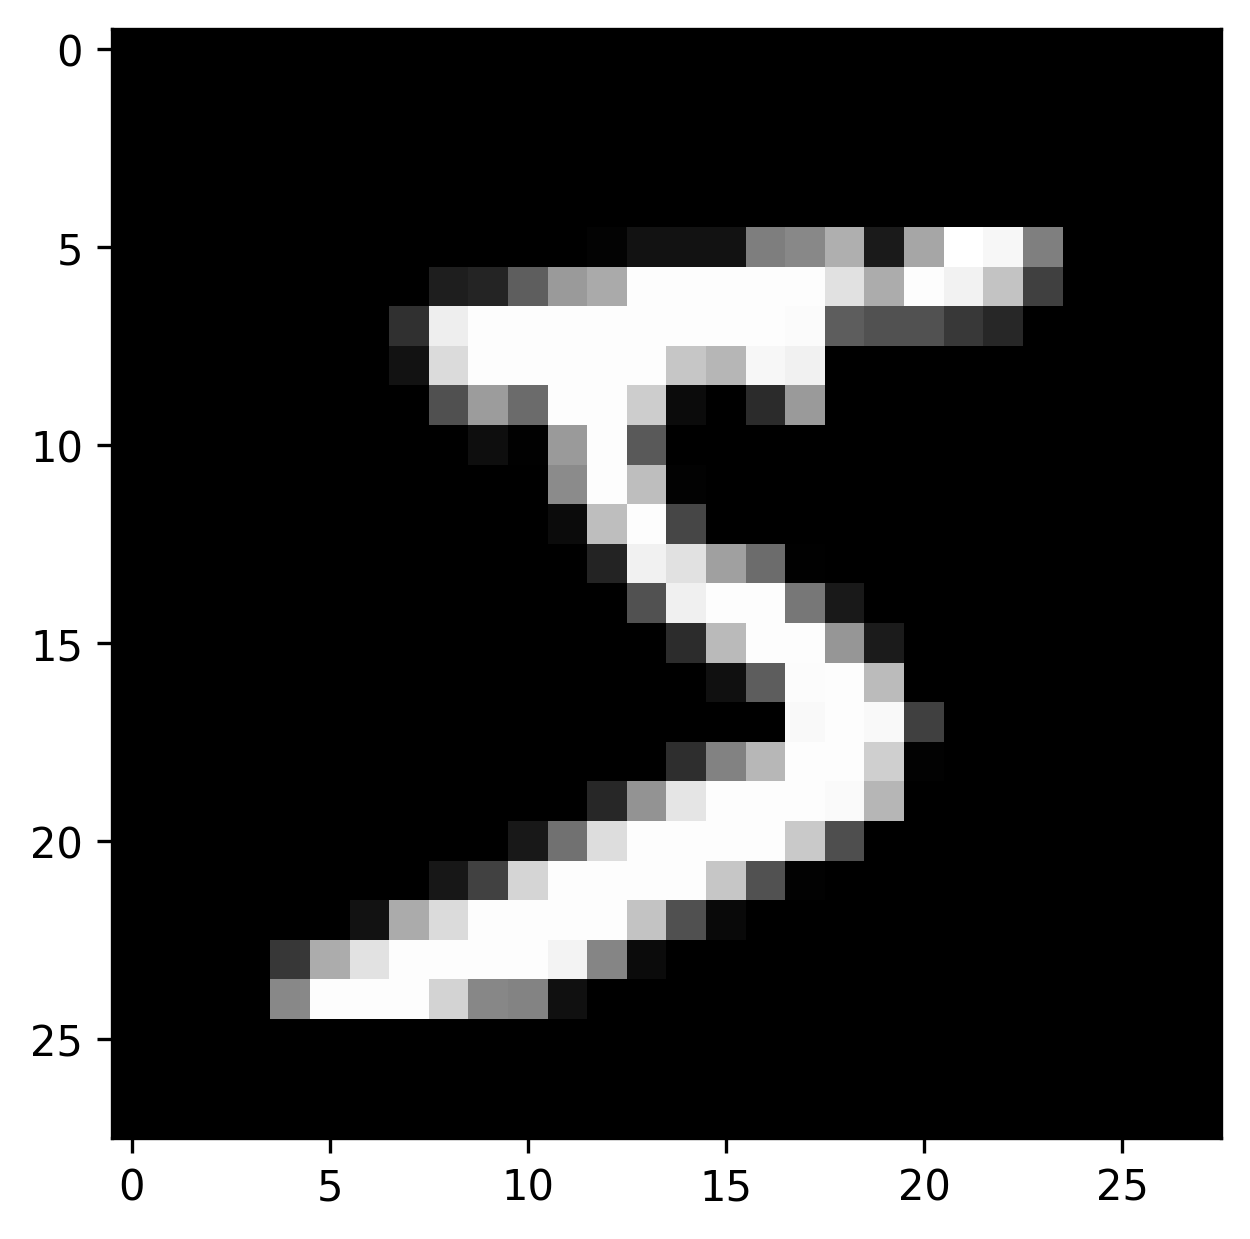

In [56]:
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
x_train.shape

In [57]:
x_train, y_train, x_test, y_test = map(torch.tensor, (x_train, y_train, x_test, y_test))
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

In [58]:
loss_func = F.cross_entropy # cross entropy loss function

batch_size = 64
x_batch = x_train[:batch_size]
y_batch = y_train[:batch_size]
weights = torch.randn(784, 10) / np.sqrt(784)
bias = torch.zeros(10, requires_grad=True)

In [59]:
def model(xb):
    return xb @ weights + bias

loss_func(model(x_batch), y_batch)

tensor(2.3300, grad_fn=<NllLossBackward0>)

In [60]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [61]:
net = Mnist_NN()
net

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)

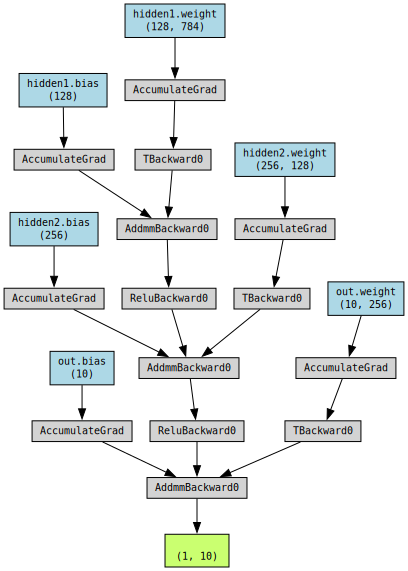

In [62]:
from torchviz import make_dot
x = torch.randn(1, 784)
y = net(x)
dot = make_dot(y, params=dict(net.named_parameters()))
dot

In [63]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_set = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [64]:
def get_data(train_set, test_set, batch_size):
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(test_set, batch_size=batch_size * 2),
    )

In [65]:
def loss_batch(model, loss_func, x_batch, y_batch, opt=None):
    loss = loss_func(model(x_batch), y_batch)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x_batch)

In [66]:
def fit(epochs, model, loss_func, opt, train_loader, test_loader):
    for epoch in trange(epochs):
        model.train() # set model to training mode
        for x_batch, y_batch in train_loader:
            loss_batch(model, loss_func, x_batch, y_batch, opt)
        model.eval() # set model to evaluation mode
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, x_batch, y_batch) for x_batch, y_batch in test_loader]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(f'Epoch: {epoch}, Loss: {val_loss}')

In [67]:
from torch import optim

def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.01)

In [68]:
train_loader, test_loader = get_data(train_set, test_set, batch_size)
model, opt = get_model()
fit(25, model, loss_func, opt, train_loader, test_loader)

  4%|▍         | 1/25 [00:00<00:22,  1.06it/s]

Epoch: 0, Loss: 0.8271345297813415


  8%|▊         | 2/25 [00:01<00:19,  1.16it/s]

Epoch: 1, Loss: 0.4298620297431946


 12%|█▏        | 3/25 [00:02<00:18,  1.21it/s]

Epoch: 2, Loss: 0.34900450637340547


 16%|█▌        | 4/25 [00:03<00:17,  1.23it/s]

Epoch: 3, Loss: 0.3154516315460205


 20%|██        | 5/25 [00:04<00:16,  1.24it/s]

Epoch: 4, Loss: 0.2886245374917984


 24%|██▍       | 6/25 [00:05<00:16,  1.12it/s]

Epoch: 5, Loss: 0.27353293269872664


 28%|██▊       | 7/25 [00:05<00:15,  1.16it/s]

Epoch: 6, Loss: 0.26001535489559174


 32%|███▏      | 8/25 [00:06<00:14,  1.18it/s]

Epoch: 7, Loss: 0.25133491262197494


 36%|███▌      | 9/25 [00:07<00:13,  1.20it/s]

Epoch: 8, Loss: 0.24054755669832228


 40%|████      | 10/25 [00:08<00:12,  1.22it/s]

Epoch: 9, Loss: 0.22627727698087693


 44%|████▍     | 11/25 [00:09<00:12,  1.14it/s]

Epoch: 10, Loss: 0.21740968673229216


 48%|████▊     | 12/25 [00:10<00:11,  1.15it/s]

Epoch: 11, Loss: 0.20766671404242515


 52%|█████▏    | 13/25 [00:11<00:10,  1.16it/s]

Epoch: 12, Loss: 0.20118588140010835


 56%|█████▌    | 14/25 [00:11<00:09,  1.19it/s]

Epoch: 13, Loss: 0.19720750190019606


 60%|██████    | 15/25 [00:12<00:08,  1.11it/s]

Epoch: 14, Loss: 0.1848738255739212


 64%|██████▍   | 16/25 [00:13<00:07,  1.15it/s]

Epoch: 15, Loss: 0.18250052250623702


 68%|██████▊   | 17/25 [00:14<00:06,  1.15it/s]

Epoch: 16, Loss: 0.176173665702343


 72%|███████▏  | 18/25 [00:15<00:05,  1.17it/s]

Epoch: 17, Loss: 0.17313774413466454


 76%|███████▌  | 19/25 [00:16<00:05,  1.15it/s]

Epoch: 18, Loss: 0.16468004264235497


 80%|████████  | 20/25 [00:17<00:04,  1.18it/s]

Epoch: 19, Loss: 0.16130270169377328


 84%|████████▍ | 21/25 [00:17<00:03,  1.19it/s]

Epoch: 20, Loss: 0.15362037492990493


 88%|████████▊ | 22/25 [00:18<00:02,  1.21it/s]

Epoch: 21, Loss: 0.14903396837711333


 92%|█████████▏| 23/25 [00:19<00:01,  1.22it/s]

Epoch: 22, Loss: 0.1452600002348423


 96%|█████████▌| 24/25 [00:20<00:00,  1.22it/s]

Epoch: 23, Loss: 0.14484833305478095


100%|██████████| 25/25 [00:21<00:00,  1.18it/s]

Epoch: 24, Loss: 0.140177887904644
